<a href="https://colab.research.google.com/github/shashank3110/MySpace/blob/master/Rmaskcnn_shapes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install mrcnn

     |████████████████████████████████| 61kB 2.3MB/s 
  Created wheel for mrcnn: filename=mrcnn-0.2-cp36-none-any.whl size=54932 sha256=fede9a181c941818b6949abe333ba233516f3fc6a37003b9b9a8cc6bebcb4583
  Stored in directory: /root/.cache/pip/wheels/11/ed/28/e550ddc897c04c336b923eae4eb35c9aae993d20ce39d9cc40
Successfully built mrcnn


In [0]:


import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)



Using TensorFlow backend.


... done downloading pretrained model!


In [0]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES

In [0]:


def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax



In [0]:
class ShapesDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_shapes(self, count, height, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("shapes", 1, "square")
        self.add_class("shapes", 2, "circle")
        self.add_class("shapes", 3, "triangle")

        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        for i in range(count):
            bg_color, shapes = self.random_image(height, width)
            self.add_image("shapes", image_id=i, path=None,
                           width=width, height=height,
                           bg_color=bg_color, shapes=shapes)

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        bg_color = np.array(info['bg_color']).reshape([1, 1, 3])
        image = np.ones([info['height'], info['width'], 3], dtype=np.uint8)
        image = image * bg_color.astype(np.uint8)
        for shape, color, dims in info['shapes']:
            image = self.draw_shape(image, shape, dims, color)
        return image

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        shapes = info['shapes']
        count = len(shapes)
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        for i, (shape, _, dims) in enumerate(info['shapes']):
            mask[:, :, i:i+1] = self.draw_shape(mask[:, :, i:i+1].copy(),
                                                shape, dims, 1)
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(s[0]) for s in shapes])
        return mask.astype(np.bool), class_ids.astype(np.int32)

    def draw_shape(self, image, shape, dims, color):
        """Draws a shape from the given specs."""
        # Get the center x, y and the size s
        x, y, s = dims
        if shape == 'square':
            cv2.rectangle(image, (x-s, y-s), (x+s, y+s), color, -1)
        elif shape == "circle":
            cv2.circle(image, (x, y), s, color, -1)
        elif shape == "triangle":
            points = np.array([[(x, y-s),
                                (x-s/math.sin(math.radians(60)), y+s),
                                (x+s/math.sin(math.radians(60)), y+s),
                                ]], dtype=np.int32)
            cv2.fillPoly(image, points, color)
        print(image)
        return image

    def random_shape(self, height, width):
        """Generates specifications of a random shape that lies within
        the given height and width boundaries.
        Returns a tuple of three valus:
        * The shape name (square, circle, ...)
        * Shape color: a tuple of 3 values, RGB.
        * Shape dimensions: A tuple of values that define the shape size
                            and location. Differs per shape type.
        """
        # Shape
        shape = random.choice(["square", "circle", "triangle"])
        # Color
        color = tuple([random.randint(0, 255) for _ in range(3)])
        # Center x, y
        buffer = 20
        y = random.randint(buffer, height - buffer - 1)
        x = random.randint(buffer, width - buffer - 1)
        # Size
        s = random.randint(buffer, height//4)
        return shape, color, (x, y, s)

    def random_image(self, height, width):
        """Creates random specifications of an image with multiple shapes.
        Returns the background color of the image and a list of shape
        specifications that can be used to draw the image.
        """
        # Pick random background color
        bg_color = np.array([random.randint(0, 255) for _ in range(3)])
        # Generate a few random shapes and record their
        # bounding boxes
        shapes = []
        boxes = []
        N = random.randint(1, 4)
        for _ in range(N):
            shape, color, dims = self.random_shape(height, width)
            shapes.append((shape, color, dims))
            x, y, s = dims
            boxes.append([y-s, x-s, y+s, x+s])
        # Apply non-max suppression wit 0.3 threshold to avoid
        # shapes covering each other
        keep_ixs = utils.non_max_suppression(np.array(boxes), np.arange(N), 0.3)
        shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]
        return bg_color, shapes

In [0]:


# Training dataset
dataset_train = ShapesDataset()
dataset_train.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
dataset_val = ShapesDataset()
dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()



In [0]:
dataset_val2 = ShapesDataset()
dataset_val2.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val2.prepare()

[[[174 132 168]
  [174 132 168]
  [174 132 168]
  ...
  [174 132 168]
  [174 132 168]
  [174 132 168]]

 [[174 132 168]
  [174 132 168]
  [174 132 168]
  ...
  [174 132 168]
  [174 132 168]
  [174 132 168]]

 [[174 132 168]
  [174 132 168]
  [174 132 168]
  ...
  [174 132 168]
  [174 132 168]
  [174 132 168]]

 ...

 [[174 132 168]
  [174 132 168]
  [174 132 168]
  ...
  [174 132 168]
  [174 132 168]
  [174 132 168]]

 [[174 132 168]
  [174 132 168]
  [174 132 168]
  ...
  [174 132 168]
  [174 132 168]
  [174 132 168]]

 [[174 132 168]
  [174 132 168]
  [174 132 168]
  ...
  [174 132 168]
  [174 132 168]
  [174 132 168]]]
[[[174 132 168]
  [174 132 168]
  [174 132 168]
  ...
  [174 132 168]
  [174 132 168]
  [174 132 168]]

 [[174 132 168]
  [174 132 168]
  [174 132 168]
  ...
  [174 132 168]
  [174 132 168]
  [174 132 168]]

 [[174 132 168]
  [174 132 168]
  [174 132 168]
  ...
  [174 132 168]
  [174 132 168]
  [174 132 168]]

 ...

 [[174 132 168]
  [174 132 168]
  [174 132 168]
  ..

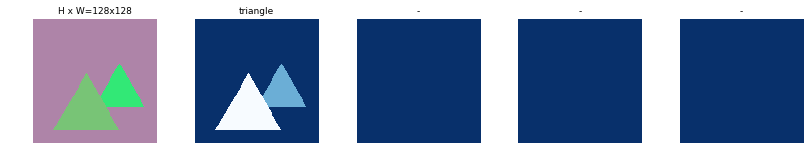

[[[ 85 242 227]
  [ 85 242 227]
  [ 85 242 227]
  ...
  [ 85 242 227]
  [ 85 242 227]
  [ 85 242 227]]

 [[ 85 242 227]
  [ 85 242 227]
  [ 85 242 227]
  ...
  [ 85 242 227]
  [ 85 242 227]
  [ 85 242 227]]

 [[ 85 242 227]
  [ 85 242 227]
  [ 85 242 227]
  ...
  [ 85 242 227]
  [ 85 242 227]
  [ 85 242 227]]

 ...

 [[ 85 242 227]
  [ 85 242 227]
  [ 85 242 227]
  ...
  [ 85 242 227]
  [ 85 242 227]
  [ 85 242 227]]

 [[ 85 242 227]
  [ 85 242 227]
  [ 85 242 227]
  ...
  [ 85 242 227]
  [ 85 242 227]
  [ 85 242 227]]

 [[ 85 242 227]
  [ 85 242 227]
  [ 85 242 227]
  ...
  [ 85 242 227]
  [ 85 242 227]
  [ 85 242 227]]]
[[[ 85 242 227]
  [ 85 242 227]
  [ 85 242 227]
  ...
  [ 85 242 227]
  [ 85 242 227]
  [ 85 242 227]]

 [[ 85 242 227]
  [ 85 242 227]
  [ 85 242 227]
  ...
  [ 85 242 227]
  [ 85 242 227]
  [ 85 242 227]]

 [[ 85 242 227]
  [ 85 242 227]
  [ 85 242 227]
  ...
  [ 85 242 227]
  [ 85 242 227]
  [ 85 242 227]]

 ...

 [[ 85 242 227]
  [ 85 242 227]
  [ 85 242 227]
  ..

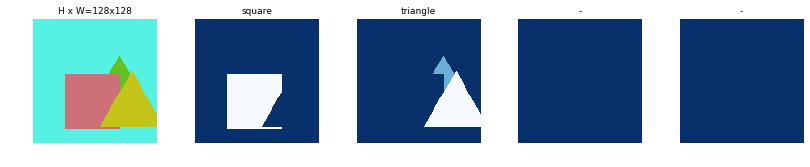

[[[194 134 171]
  [194 134 171]
  [194 134 171]
  ...
  [194 134 171]
  [194 134 171]
  [194 134 171]]

 [[194 134 171]
  [194 134 171]
  [194 134 171]
  ...
  [194 134 171]
  [194 134 171]
  [194 134 171]]

 [[194 134 171]
  [194 134 171]
  [194 134 171]
  ...
  [194 134 171]
  [194 134 171]
  [194 134 171]]

 ...

 [[194 134 171]
  [194 134 171]
  [194 134 171]
  ...
  [194 134 171]
  [194 134 171]
  [194 134 171]]

 [[194 134 171]
  [194 134 171]
  [194 134 171]
  ...
  [194 134 171]
  [194 134 171]
  [194 134 171]]

 [[194 134 171]
  [194 134 171]
  [194 134 171]
  ...
  [194 134 171]
  [194 134 171]
  [194 134 171]]]
[[[194 134 171]
  [194 134 171]
  [194 134 171]
  ...
  [194 134 171]
  [194 134 171]
  [194 134 171]]

 [[194 134 171]
  [194 134 171]
  [194 134 171]
  ...
  [194 134 171]
  [194 134 171]
  [194 134 171]]

 [[194 134 171]
  [194 134 171]
  [194 134 171]
  ...
  [194 134 171]
  [194 134 171]
  [194 134 171]]

 ...

 [[194 134 171]
  [194 134 171]
  [194 134 171]
  ..

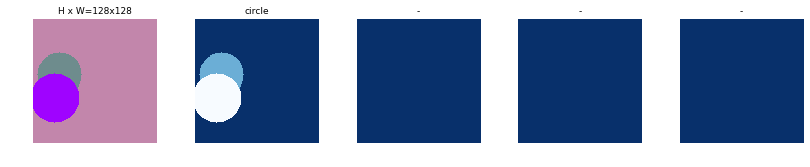

[[[ 41  43 107]
  [ 41  43 107]
  [ 41  43 107]
  ...
  [ 41  43 107]
  [ 41  43 107]
  [ 41  43 107]]

 [[ 41  43 107]
  [ 41  43 107]
  [ 41  43 107]
  ...
  [ 41  43 107]
  [ 41  43 107]
  [ 41  43 107]]

 [[ 41  43 107]
  [ 41  43 107]
  [ 41  43 107]
  ...
  [ 41  43 107]
  [ 41  43 107]
  [ 41  43 107]]

 ...

 [[ 41  43 107]
  [ 41  43 107]
  [ 41  43 107]
  ...
  [ 41  43 107]
  [ 41  43 107]
  [ 41  43 107]]

 [[ 41  43 107]
  [ 41  43 107]
  [ 41  43 107]
  ...
  [ 41  43 107]
  [ 41  43 107]
  [ 41  43 107]]

 [[ 41  43 107]
  [ 41  43 107]
  [ 41  43 107]
  ...
  [ 41  43 107]
  [ 41  43 107]
  [ 41  43 107]]]
[[[ 41  43 107]
  [ 41  43 107]
  [ 41  43 107]
  ...
  [ 41  43 107]
  [ 41  43 107]
  [ 41  43 107]]

 [[ 41  43 107]
  [ 41  43 107]
  [ 41  43 107]
  ...
  [ 41  43 107]
  [ 41  43 107]
  [ 41  43 107]]

 [[ 41  43 107]
  [ 41  43 107]
  [ 41  43 107]
  ...
  [ 41  43 107]
  [ 41  43 107]
  [ 41  43 107]]

 ...

 [[ 41  43 107]
  [ 41  43 107]
  [ 41  43 107]
  ..

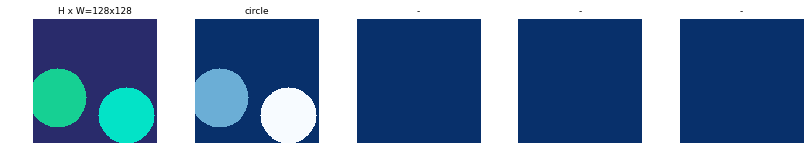

In [0]:


# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)



In [0]:


# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)









Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [0]:


# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)



In [0]:


# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')




Starting at epoch 0. LR=0.001

Checkpoint Path: /logs/shapes20191001T0725/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDis

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple worker

In [0]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")

In [0]:
import os 
##this downloads the compressed model hence not preferred 
# from google.colab import files
# p='/logs/shapes20190930T1336/'

# for f in os.listdir(p):
#   if '2.h5' in f:
#     mpath = p+f
#     print(mpath)
#     files.download(mpath)


## Instead Use this way:
# from google.colab import auth
# from googleapiclient.http import MediaFileUpload
# from googleapiclient.discovery import build

# auth.authenticate_user()




# from google.colab import auth
# from googleapiclient.http import MediaFileUpload
# from googleapiclient.discovery import build

# auth.authenticate_user()



# drive_service = build('drive', 'v3')

# def save_file_to_drive(name, path):
#     file_metadata = {
#       'name': name,
#       'mimeType': 'application/octet-stream'
#      }

#      media = MediaFileUpload(path, 
#                     mimetype='application/octet-stream',
#                     resumable=True)

#      created = drive_service.files().create(body=file_metadata,
#                                    media_body=media,
#                                    fields='id').execute()

#      print('File ID: {}'.format(created.get('id')))

#      return created
  
# #save_file_to_drive(destination_path,source_file)
# save_file_to_drive('mask_rcnn_shapes_destination.h5', '/logs/shapes20190930T1336/mask_rcnn_shapes_0002.h5')

In [0]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
#model_path = model.find_last()
model_path = '/logs/shapes20190930T1336/mask_rcnn_shapes_0002.h5'#/logs/shapes20190926T1324'
# # Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)
#model.load_weights(model.find_last(), by_name=True)

In [0]:
#!cd /logs/shapes20190926T1340/
dir(model)
#type(model)

In [0]:
#kmodel=model.keras_model()

In [0]:
import os 
p='/logs/shapes20190930T1336/'
for f in os.listdir(p):
  print(f)
  print(os.stat(p+f).st_size)
  

In [0]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)
print(type(original_image))
visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [0]:
!pip3 install scikit-image

In [0]:
#!wget -nv https://github.com/shashank3110/models/blob/master/research/deeplab/g3doc/img/img.png?raw=true -O img.png
#im=plt.imread('./color_22.png')  
import skimage
im= skimage.io.imread('./wz28_Color.png')

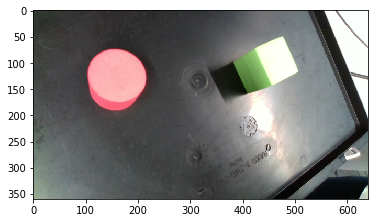

In [67]:
plt.imshow(im)

Processing 1 images
image                    shape: (360, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  640.00000  float64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
<class 'imageio.core.util.Array'>
{'rois': array([[ 76,  79, 216, 249],
       [ 11, 364, 347, 640],
       [ 28,   0, 331, 615]], dtype=int32), 'class_ids': array([2, 1, 2], dtype=int32), 'scores': array([0.97877973, 0.87479   , 0.78544915], dtype=float32), 'masks': array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, 

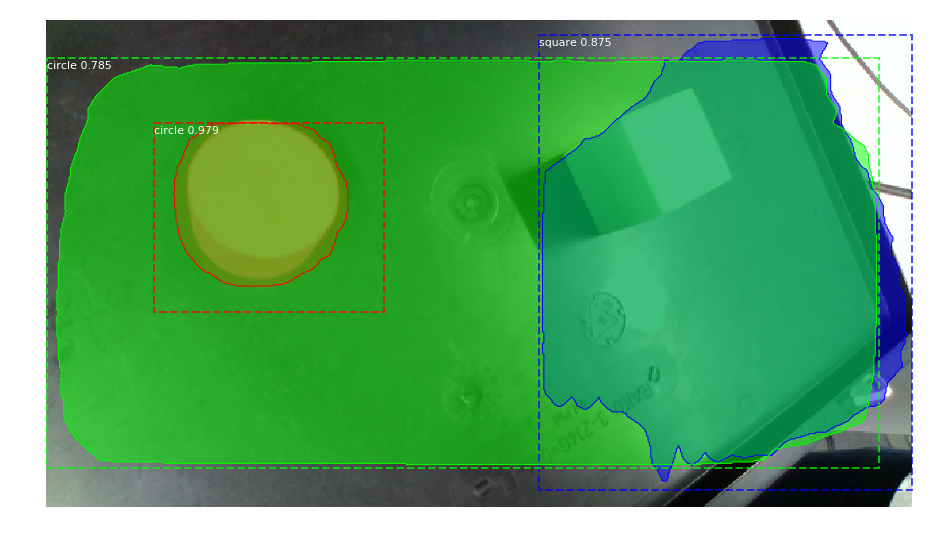

In [68]:
results = model.detect([im], verbose=1)
print(type(im))
# Visualize results
r = results[0]
print(r)
visualize.display_instances(im, r['rois'], r['masks'], r['class_ids'], dataset_train.class_names, r['scores'])

In [0]:
!cd /logs/shapes20190926T1324
!ls
!pwd
!cd ..
!pwd

In [0]:
config.NAME
#tf.keras.models.save_model(model,'shape_model.h5')

In [0]:
# Build validation dataset
if config.NAME == 'shapes':
    dataset = shapes.ShapesDataset()
    dataset.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
elif config.NAME == "coco":
    dataset = coco.CocoDataset()
    dataset.load_coco(COCO_DIR, "minival")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

In [0]:
DEVICE = "/gpu:0"
SHAPES_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_shapes.h5")
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

# Set weights file path
if config.NAME == "shapes":
    weights_path = SHAPES_MODEL_PATH
elif config.NAME == "coco":
    weights_path = COCO_MODEL_PATH
# Or, uncomment to load the last model you trained
# weights_path = model.find_last()

In [0]:
model.checkpoint_path

In [0]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

In [0]:
!apt-get install mutt

In [0]:
!echo "Message Body Here" | mutt -s "Subject Here" -a  /logs/shapes20190930T1336/mask_rcnn_shapes_0002.h5 shashank311095@gmail.com